In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

# Word2Vec
word2vec은 "word to vector"의 줄임말입니다. 즉 단어를 벡터로 변환시킨 값이라고 볼 수 있습니다.  
word2Vec의 장점은 크게 두가지로 볼 수 있습니다. 

1. 의미가 비슷한 단어는 벡터 공간에서 서로 가까운 위치에 존재하게 된다. (King - Man + Woman = Queen)
2. 비지도 학습(unsupervised learning)으로 말뭉치 데이터만 있으면 쉽게 word2vec을 구할 수 있다. (label이 자동생성되는 장점!)

이번 실습에서는 텐서플로우를 활용하여 아주 간단한 word2vec 모델을 만들어보도록 하겠습니다.  

# 데이터 획득
아주 간단한 실습을 위해, 아래 10개의 문장을 사용해보도록 하겠습니다.

In [2]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

# stop words 제거하기
stop words란 학습에 도움이 되지도 않으면서 빈번하게 발생되는 단어를 의미합니다.  
효율적인 학습을 위해서 stop words를 데이터에서 제거하겠습니다.

In [3]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [4]:
corpus = remove_stop_words(corpus)

stop words가 제거된 문장들을 확인해보겠습니다.

In [5]:
for text in corpus:
    print(text)

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [6]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

stop words를 제거한 후, 데이터에 존재하는 단어들은 다음과 같습니다.

In [7]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

# 단어별 인덱스 매핑 테이블 만들기
단어를 one hot encoding으로 변환하기 위해서 가장 먼저 인덱스로 인코딩을 해줘야합니다.  
key는 단어이고, value는 인덱스인 딕셔너리를 만들어줍니다. 이 딕셔너리는 단어를 손쉽게 인덱싱하기 위해 사용됩니다. 

In [8]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

각 단어의 인덱스를 확인해보도록 하겠습니다.

In [9]:
word2int

{'young': 0,
 'man': 1,
 'woman': 2,
 'girl': 3,
 'strong': 4,
 'princess': 5,
 'prince': 6,
 'pretty': 7,
 'king': 8,
 'wise': 9,
 'queen': 10,
 'boy': 11}

# 레이블 생성
skip gram 방식으로 각 단어별 레이블을 생성하도록 하겠습니다.

In [10]:
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[ \
                max(idx - WINDOW_SIZE, 0) : \
                min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

각 단어별 레이블을 살펴보도록 하겠습니다. window size가 2이므로, 각 단어별 두개의 

In [11]:
df = pd.DataFrame(data, columns = ['input', 'label'])
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


# 텐서플로우로 word2vec 모델 구현하기

In [12]:
ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.truncated_normal(
    [ONE_HOT_DIM, EMBEDDING_DIM], stddev=0.1))
hidden_layer = tf.matmul(x,W1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(
    -tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

# 학습

In [13]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', \
              sess.run(loss, 
                       feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  2.4870172
iteration 3000 loss is :  2.0799875
iteration 6000 loss is :  1.8927555
iteration 9000 loss is :  1.8159293
iteration 12000 loss is :  1.7777979
iteration 15000 loss is :  1.7557793
iteration 18000 loss is :  1.7416725


# word2vec 추출하기
학습이 완료된 모델에서 W1을 추출합니다. W1이 우리가 찾고자 하는 word2vec입니다.  
입력값이 one hot encoding이어서, W1 x input의 값은 그대로 W1값과 동일하기 때문에 W1의 값이 바로 word2vec이 되는 것입니다.  
아래의 그림을 통해 W1이 word2vec임을 이해하실 수 있습니다.

In [14]:
# Now the hidden layer (W1) is actually the word look up table
vectors = sess.run(W1)
print(vectors)

[[-0.12193391  0.38735035]
 [-1.6336827  -2.1255336 ]
 [ 0.9168142  -0.52313685]
 [ 1.9271171  -0.400311  ]
 [-1.8456203   1.523467  ]
 [ 2.570482   -1.0459292 ]
 [-1.71274    -1.7724113 ]
 [ 1.3452445   1.4979398 ]
 [-0.72232956 -0.78011453]
 [ 2.3952246  -0.05965375]
 [ 0.9966461  -0.08075511]
 [-0.8309311  -0.6007161 ]]


# word2vec의 좌표값
아래 코드를 실행하여 2d 챠트에서의 각 단어의 좌표값을 볼 수 있습니다.

In [15]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,young,-0.121934,0.387350
1,man,-1.633683,-2.125534
2,woman,0.916814,-0.523137
3,girl,1.927117,-0.400311
4,strong,-1.845620,1.523467
5,princess,2.570482,-1.045929
6,prince,-1.712740,-1.772411
7,pretty,1.345245,1.497940
8,king,-0.722330,-0.780115
9,wise,2.395225,-0.059654


# word2vec를 2차원 공간에 시각화하기
좌표값을 활용하여 2차원 공간에 word2vec을 시각화하겠습니다.

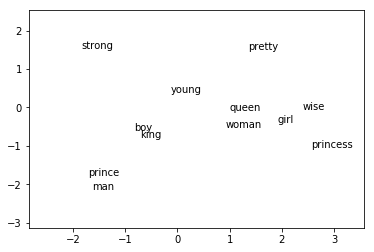

In [16]:
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()

시각화를 통해 비슷한 단어들이 서로 가까운 위치에 있는 것을 확인할 수 있습니다.  
예를 들면 prince, man, boy, king이 서로 비슷한 위치에 군집해있고,  
princess, girl, woman 역시 서로 비슷한 위치에 군집해 있는 것을 확인 가능합니다.  
단어의 의미론적 유사도를 가지고 있는 word2vec은 딥러닝을 활용한 자연어처리 분야에서 큰 발전을 이끌어나가고 있습니다.

# 참고자료
McCormick, C. (2016, April 19). Word2Vec Tutorial - The Skip-Gram Model.   
https://arxiv.org/pdf/1301.3781.pdf